In [1]:
%env PATH=/usr/local/cuda-11.5/bin:$PATH

env: PATH=/usr/local/cuda-11.5/bin:$PATH


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [5]:
from pinns.prelude import *
from pinns.model import mlp
from pinns.domain import Sphere
from pinns.calc import laplace, divergence
from pinns.opt import run_epoch
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt

In [6]:
domain = Sphere(1., (0., 0., 0.))
x_dom = array(Sobol(3, seed=0).random_base2(10))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(8))
x_bnd = domain.transform_bnd(x_bnd)


@jit
def make_batches(rng, phi=None):
    batches = 24
    k1, k2 = random.split(rng)
    batch_size_dom = x_dom.shape[0] // batches
    batch_size_bnd = x_bnd.shape[0] // batches

    perms_dom = jax.random.permutation(k1, x_dom.shape[0])
    perms_dom = perms_dom[:batches * batch_size_dom]  # skip incomplete batch
    perms_dom = perms_dom.reshape((batches, batch_size_dom))

    perms_bnd = jax.random.permutation(k2, x_bnd.shape[0])
    perms_bnd = perms_bnd[:batches * batch_size_bnd]  # skip incomplete batch
    perms_bnd = perms_bnd.reshape((batches, batch_size_bnd))

    if phi is None:
        return x_dom[perms_dom, :], x_bnd[perms_bnd, :]
    else:
        return x_dom[perms_dom, :], x_bnd[perms_bnd, :], phi[perms_bnd]

In [17]:
key, subkey = random.split(random.PRNGKey(42), 2)
phi1, params = mlp(subkey, [3, 20, 20, 20, 1])
tx = optax.adam(0.001)

init_state1 = TrainState.create(
    apply_fn=phi1.apply,
    params=params['params'], 
    tx=tx
)

def mag(x):
    return array([0., 0., 1.])


def loss1(params, x_dom, x_bnd):
    _pde_loss = lambda x, _, p: (1/2 * sum(grad(phi1.apply, 1)(p, x) ** 2) - divergence(mag)(x) * phi1.apply(p, x))
    _bnd_loss = lambda _, x, p: (phi1.apply(p, x)) ** 2

    pde_loss = mean(vmap(_pde_loss, (0, None, None))(x_dom, x_bnd, params))
    bnd_loss = mean(vmap(_bnd_loss, (None, 0, None))(x_dom, x_bnd, params))
    _loss = pde_loss + bnd_loss
    return _loss, {'pde_loss': pde_loss, 'bnd_loss': bnd_loss, 'loss': _loss}

In [18]:

state1 = init_state1
for epoch in range(0, 4000):
    key, subkey = random.split(key)
    data = make_batches(subkey)
    state1, epoch_metrics = run_epoch(state1, loss1, data)
    if epoch % 100 == 0:
        epoch_metrics = tree_map(mean, epoch_metrics)
        print(f"train epoch: {epoch}, pde_loss: {epoch_metrics['pde_loss']:.4e}, bnd_loss: {epoch_metrics['bnd_loss']:.4e}")

params1 = {'params': state1.params}

train epoch: 0, pde_loss: -3.2431e-01, bnd_loss: 4.4941e-02
train epoch: 100, pde_loss: -4.9604e+00, bnd_loss: 2.2553e+00
train epoch: 200, pde_loss: -4.9645e+00, bnd_loss: 2.2356e+00
train epoch: 300, pde_loss: -5.0640e+00, bnd_loss: 2.3339e+00
train epoch: 400, pde_loss: -4.9912e+00, bnd_loss: 2.2598e+00
train epoch: 500, pde_loss: -4.9783e+00, bnd_loss: 2.2555e+00
train epoch: 600, pde_loss: -5.0022e+00, bnd_loss: 2.2743e+00
train epoch: 700, pde_loss: -5.0061e+00, bnd_loss: 2.2572e+00
train epoch: 800, pde_loss: -4.9389e+00, bnd_loss: 2.1935e+00
train epoch: 900, pde_loss: -5.0207e+00, bnd_loss: 2.2808e+00
train epoch: 1000, pde_loss: -4.9648e+00, bnd_loss: 2.2162e+00
train epoch: 1100, pde_loss: -4.9429e+00, bnd_loss: 2.2322e+00
train epoch: 1200, pde_loss: -4.9611e+00, bnd_loss: 2.2277e+00
train epoch: 1300, pde_loss: -4.9189e+00, bnd_loss: 2.1909e+00
train epoch: 1400, pde_loss: -4.9579e+00, bnd_loss: 2.2345e+00
train epoch: 1500, pde_loss: -5.0065e+00, bnd_loss: 2.2689e+00
trai

In [19]:
def phi2_solution(x, x_bnd):
    eps = 1e-7
    def g(y):
        n = y / norm(y, axis=-1)
        return dot(mag(y), n) - dot(grad(phi1.apply, 1)(params1, y), n)
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return (4 * pi * 1. ** 2) / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)

In [20]:
_x_bnd = array(Sobol(2, seed=123).random_base2(15))
_x_bnd = domain.transform_bnd(_x_bnd)
phi_bnd = phi2_solution(x_bnd, _x_bnd)

In [21]:
key, subkey = random.split(key, 2)
phi2, params2 = mlp(subkey, [3, 40, 40, 1])

tx = optax.adam(0.001)
init_state2 = TrainState.create(
    apply_fn=phi2.apply, 
    params=params2['params'],
    tx=tx
)

def loss2(params, x_dom, x_bnd, y_bnd):
    _pde_loss = lambda x, _, y, p: (1/2 * sum(grad(phi2.apply, 1)(p, x) ** 2))
    _bnd_loss = lambda _, x, y, p: (phi2.apply(p, x) - y) ** 2

    pde_loss = mean(vmap(_pde_loss, (0, None, None, None))(x_dom, x_bnd, y_bnd, params))
    bnd_loss = mean(vmap(_bnd_loss, (None, 0, 0, None))(x_dom, x_bnd, y_bnd, params))
    _loss = pde_loss + 100*bnd_loss
    return _loss, {'pde_loss': pde_loss, 'bnd_loss': bnd_loss, 'loss': _loss}


In [22]:
state2 = init_state2
for epoch in range(0, 3000):
    key, subkey = random.split(key)
    data = make_batches(subkey, phi_bnd)
    state2, epoch_metrics = run_epoch(state2, loss2, data)
    if epoch % 100 == 0:
        epoch_metrics = tree_map(mean, epoch_metrics)
        print(f"train epoch: {epoch}, pde_loss: {epoch_metrics['pde_loss']:.4e}, bnd_loss: {epoch_metrics['bnd_loss']:.4e}")

params2 = {'params': state2.params}


train epoch: 0, pde_loss: 3.0816e-02, bnd_loss: 3.4310e+00
train epoch: 100, pde_loss: 5.9697e-02, bnd_loss: 1.6475e-04
train epoch: 200, pde_loss: 2.3428e-02, bnd_loss: 2.0606e-04
train epoch: 300, pde_loss: 8.1981e-03, bnd_loss: 3.7534e-04
train epoch: 400, pde_loss: 3.4487e-03, bnd_loss: 2.6936e-04
train epoch: 500, pde_loss: 1.9842e-03, bnd_loss: 1.8934e-04
train epoch: 600, pde_loss: 1.3228e-03, bnd_loss: 1.1230e-04
train epoch: 700, pde_loss: 1.0738e-03, bnd_loss: 1.6648e-04
train epoch: 800, pde_loss: 8.5288e-04, bnd_loss: 1.5398e-04
train epoch: 900, pde_loss: 7.1309e-04, bnd_loss: 2.0930e-04
train epoch: 1000, pde_loss: 7.0273e-04, bnd_loss: 1.4639e-04
train epoch: 1100, pde_loss: 6.2925e-04, bnd_loss: 1.2875e-04
train epoch: 1200, pde_loss: 5.6111e-04, bnd_loss: 1.6969e-04
train epoch: 1300, pde_loss: 4.8501e-04, bnd_loss: 1.1960e-04
train epoch: 1400, pde_loss: 4.7863e-04, bnd_loss: 1.2568e-04
train epoch: 1500, pde_loss: 4.6254e-04, bnd_loss: 1.0826e-04
train epoch: 1600, p

In [26]:

def nn_solution(x):
    return phi1.apply(params1, x) + phi2.apply(params2, x)


y_sol1 = phi1.apply(params1, x_dom) + phi2_solution(x_dom, x_bnd)
y_sol2 = nn_solution(x_dom)
y_analytic = x_dom[:, 2] / 3
mean((y_analytic - y_sol2) ** 2)

DeviceArray(15.666321, dtype=float32)

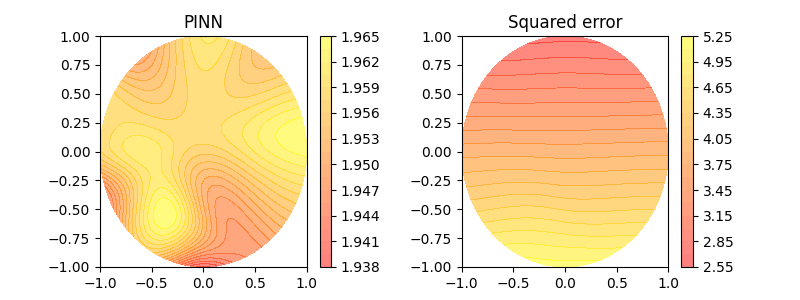

In [27]:
import itertools
import numpy as np

def plot_sol(sol, ax):
    plt.sca(ax)
    N = 1000
    x = np.linspace(-1, 1, N)
    z = np.linspace(-1, 1, N)
    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))
    phi[np.linalg.norm(X, axis=-1) > 1.] = np.nan

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    plt.colorbar(p)

fig = plt.figure(figsize=(8, 3))
ax1, ax2 = fig.subplots(1, 2)
plt.subplots_adjust(wspace=0.4)
ax1.set_title("PINN")
plot_sol(lambda x: phi2.apply(params2, x), ax1)
ax2.set_title("Squared error")
plot_sol(lambda x: (x[..., 2] / 3 -  phi2.apply(params2, x)) ** 2, ax2)

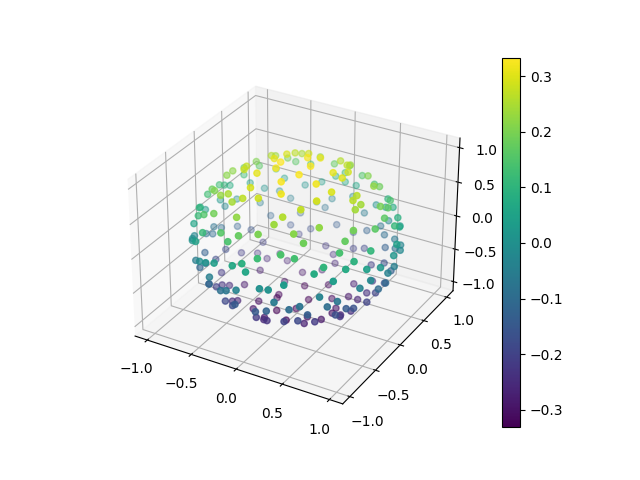

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(x_bnd[:, 0], x_bnd[:, 1], x_bnd[:, 2], c=phi_bnd[:])
plt.colorbar(p)